# Exploratory Analysis of the Data with PCA

### Goals
1. Reduce the dimensionality of the data
    * Determine the optimal number of principal components required to explain 95% of the variance.
2. Create visuals of the data in 2- and 3-dimensions.
3. Get a feel for the data set.

### Notes getting into this:
* The headers of the initial CSV file given to us contained an error. I had to manually edit the first column header to
ensure that it may be loaded properly.
* The data contain no null or blank fields
* All the data are numerical -- no need to apply a type of encoding.

In [62]:
import numpy as np
from models.data_loader import DataLoader
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Ensure that the model has a fixed random state, for reproducibility.
rs = np.random.RandomState(42069)

### Load the data
Load the data, separating the design matrix from the ground truths.

In [63]:
# Load the wine quality dataset
data_loader = DataLoader('../data/winequality-red.csv', random_state=rs)

# Extract the data, separating the design matrix from the ground truths
X, y = data_loader.get_all_data()

N, d = X.shape

### Standardize the Data
PCA expects the data to have zero-mean. Therefore, it makes sense to apply standard scaling to have zero mean and unit
variance.

In [64]:
standard_scalar = StandardScaler()
X_standardized = standard_scalar.fit_transform(X)

# print(standard_scalar.mean_)

### PCA
Apply PCA against the data. Begin by trying to visualize the dataset in both 2 and 3 dimensions.

Notes: watched the tutorial here https://www.youtube.com/watch?v=aOObCbQkVKw to get some intuition on how best to apply
the model.

Explained variance by first 2 components: [0.28173931 0.1750827 ]


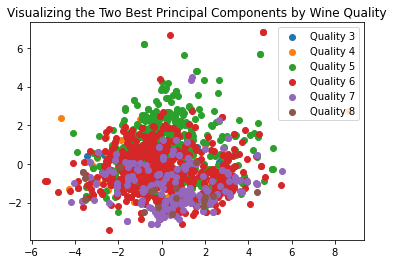

In [65]:
pca = PCA(n_components=2, random_state=rs)
X_scaled = pca.fit_transform(X_standardized)

print(f"Explained variance by first 2 components: {pca.explained_variance_ratio_}")

qualities = np.unique(y)

for i in qualities:
    plt.scatter(X_scaled[y==i, 0], X_scaled[y==i, 1], label=f'Quality {int(i)}')

plt.title("Visualizing the Two Best Principal Components by Wine Quality")
plt.legend()
plt.savefig('../images/pca_2_components')
plt.show()

#### What was learned?
1. There are only wine qualities 3-8, despite the scale being from 0 to 10.
2. There are some outliers (e.g., most values near the top of the image)
3. More components will be needed to explain the data well.

### Determining Which Components Explain the Data
We will want to explain 95% of the data with as few components as possible. Let's determine how many are required.

Total model variance: 11.00688360450564
95% model variance: 10.456539424280358


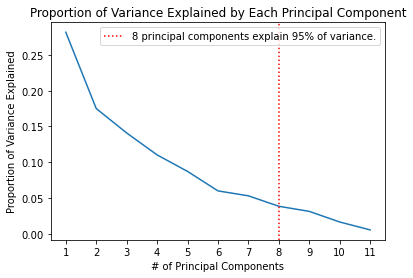

In [66]:
# Apply PCA with the maximum number of components to find the total variance, and the 95% variance target.
pca = PCA(n_components=d, random_state=rs)
pca.fit(X_standardized)

variance_total = np.sum(pca.explained_variance_)
print(f"Total model variance: {variance_total}")

variance_95 = 0.95 * variance_total
print(f"95% model variance: {variance_95}")

# Determine how many principal components are required to explain 95% of the variance
variance_explained = np.cumsum(pca.explained_variance_)

# The first number of principal components which explain 95% of the variance will be the first spot to have a value
# greater than `variance_95` in the `variance_explained`.
n_components_required = np.min(np.argwhere(variance_explained >= variance_95))

# Plot the explained variance by each component
indices = np.arange(d)+1
plt.plot(indices, pca.explained_variance_ratio_)
plt.axvline(n_components_required, linestyle=":", c="red", label=f"{n_components_required} principal components explain " +
            "95% of variance.")
plt.title("Proportion of Variance Explained by Each Principal Component")
plt.xlabel("# of Principal Components"); plt.xticks(indices)
plt.ylabel("Proportion of Variance Explained")
plt.legend()
plt.savefig("../images/n_components_explain_95_variance")
plt.show()

### Lastly, attempt plotting the data in 3D
I do not expect much to come from this as only about 60% of the data is explained by the first three components.
However, that is a decent improvement over the 45% that is explained by the first two components.

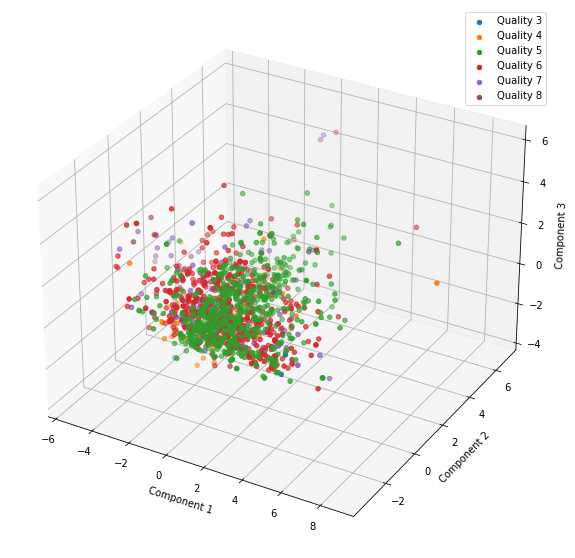

In [69]:
# Referenced: https://matplotlib.org/stable/gallery/mplot3d/scatter3d.html

pca = PCA(n_components=3, random_state=rs)
X_scaled = pca.fit_transform(X_standardized)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

for quality in qualities:
    ax.scatter(X_scaled[y==quality, 0], X_scaled[y==quality, 1], X_scaled[y==quality, 2], label=f'Quality {int(quality)}')

ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
plt.legend()

plt.savefig("../images/pca_3_components")
plt.show()

### What was learned?
Well, as expected, including more components allowed for more outliers to be seen. It's difficult to judge the data from
such a low-dimensional viewpoint (especially as we've already seen that 8 are required to explain 95% of the data), but
this helps confirm the existence of some clusters in the data. Which model will be has yet to be determined, but a
multi-class SVM would be a good starting point.